# Business Understanding

**Descriptions of the tasks to deliver on:**

Task 1:
Through EDA find at least 3 useful insights in the dataset, that could be used as recommendations for house sellers and/or buyers

Task 2:
Model the dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible (R-squared: 0.7 to 0.9)

# Data Mining

Resetting the local namespace, importing the necessary modules, setting the plotting style and reading the csv file containing the raw data

In [113]:
reset -fs

In [114]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(11.7,8.27)})

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [115]:
# Importing the dataset and first glance into the different available features
df = pd.read_csv("/Users/tjadeappel/nf-sep-20/2020-ds-Project-EDA/King_County_House_prices_dataset.csv", na_values="?")
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

Key Questions:  
1. What types of data does the dataset contain?
2. Do any values have to be converted in their type?
3. Are their missing values? If yes, how many and how should they be handled?
4. Are their outliers? If yes, how should they be handled?

In [116]:
# What types of data does the dataset contain
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


In [117]:
# Check for missing values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
waterfront,2376,11.0
view,63,0.3
sqft_basement,454,2.1
yr_renovated,3842,17.8


0.0    19075
1.0      146
Name: waterfront, dtype: int64


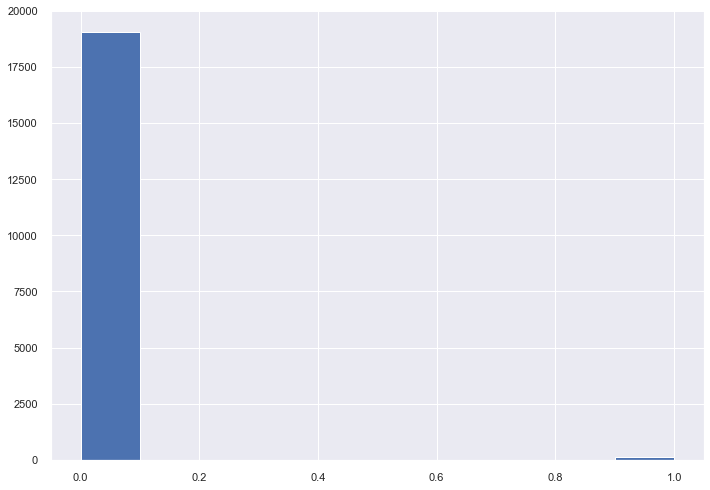

In [118]:
# What is the distribution of houses with a waterfront?
print(df.waterfront.value_counts())
df.waterfront.hist();

In [119]:
# Only very few houses have waterfronts --> Assumption: Houses with no value in column don't have a waterfront.
# Therefore those are replaced with 0.
df.waterfront.fillna(value = 0, inplace = True)

0.0


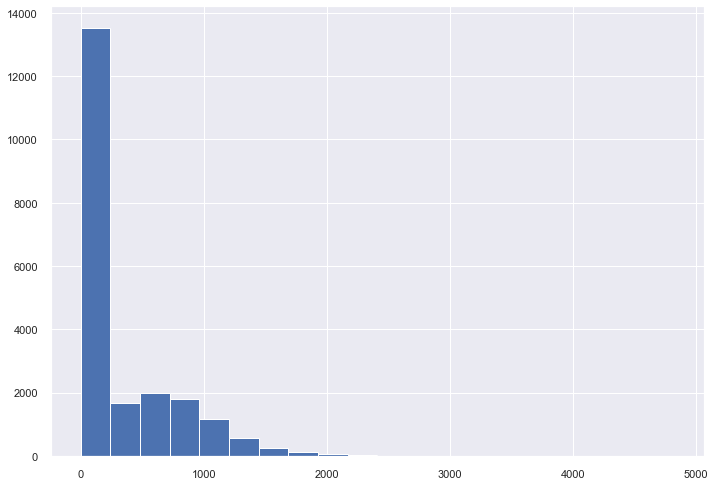

In [120]:
# What is the distribution of sqft_basement values?
df.sqft_basement.hist(bins = 20)
print(df.sqft_basement.median())

In [121]:
# Most houses dont seem to have a basement. Therefore the assumption is that missing values can be filled with the median, which is 0.
df.sqft_basement.fillna(value = 0, inplace = True)

# Dropping rows with missing columns for view due to the very small percentage of missing values.
df.dropna(subset = ["view"], inplace=True)

# The column id does not deliver any information, which is why it will be dropped.
df.drop("id", axis = 1, inplace = True)

In [122]:
# Yr_built and yr_renovated are merged into a new feature (age_lastchange) and the respective columns are dropped.
df["yr_lastchange"] = df[["yr_built", "yr_renovated"]].max(axis=1)
df['sales_yr']=df['date'].astype(str).str[-4:]
df['age_lastchange']=df['sales_yr'].astype(int)-df['yr_lastchange']
df.drop(['yr_lastchange',"yr_built", "yr_renovated","sales_yr","date"], axis = 1, inplace = True)

# Data Exploration

1. Which features are continuous variables and which are categorical?
2. Check for correlations between features and label.
3. Check for correlations between features.
4. What recommendations can be made to potential house sellers/buyers?

## 3 Recommendations

### Best price / sq ft living area
In which area/zip code should a client be looking, if he or she is trying to get the best price / sq ft living area ratio?

In [123]:
# Adding column for the searched label
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]

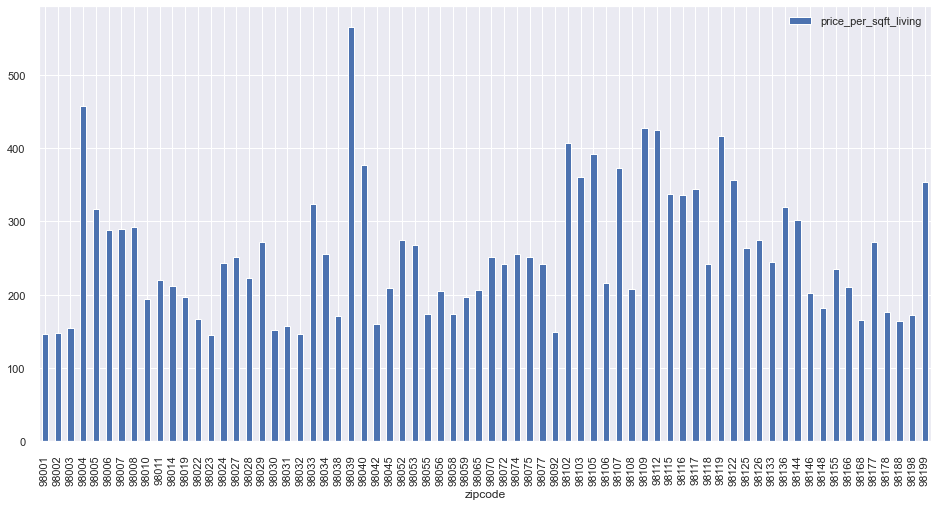

In [124]:
# Plotting a barchart for the median price / sq ft living by zipcode 
median_price_per_sqft_living_by_zipcode = df.groupby("zipcode").median()["price_per_sqft_living"].reset_index()
median_price_per_sqft_living_by_zipcode.plot(kind = "bar", x = "zipcode", y = "price_per_sqft_living", figsize = (16,8));

In [125]:
# Grabbing the 3 cheapest zipcodes
median_price_per_sqft_living_by_zipcode.sort_values(["price_per_sqft_living"], ascending = True, inplace = True)
median_price_per_sqft_living_by_zipcode.head(3)

,zipcode,price_per_sqft_living
13,98023,144.886364
20,98032,146.202094
0,98001,146.759259


In [126]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

### Value of King County grade for sellers
How valuable is a good grade by the King County grading system for a house seller, if he or she wants to sell for a higher price than usual?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


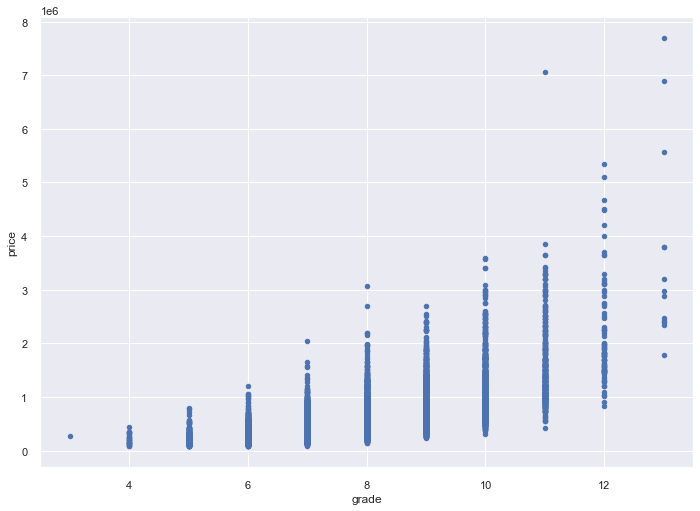

In [127]:
# Plotting all data points (price over grade)
df.plot(x = "grade", y = "price", kind = "scatter");

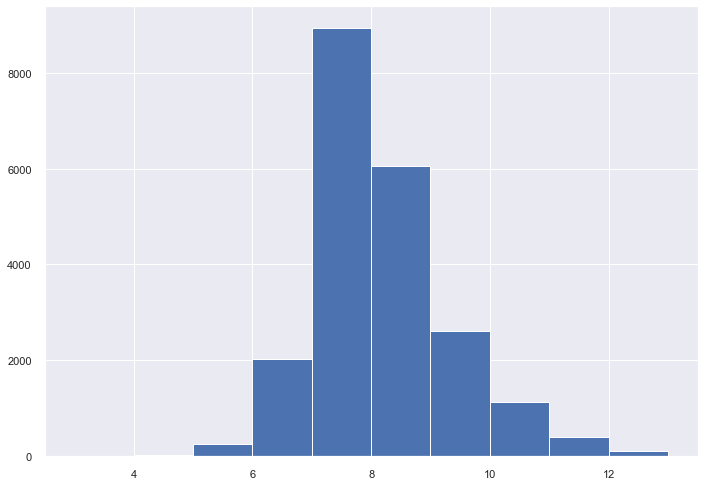

In [128]:
# Distribution of given grades
df.grade.hist();

In [129]:
# Checking the median price in King County and the median price grouped by grade category
print(df.price.median())
df.groupby("grade").median()["price"]

450000.0


grade
3      262000.0
4      200000.0
5      228700.0
6      275500.0
7      375000.0
8      510000.0
9      721750.0
10     913077.0
11    1280000.0
12    1820000.0
13    2980000.0
Name: price, dtype: float64

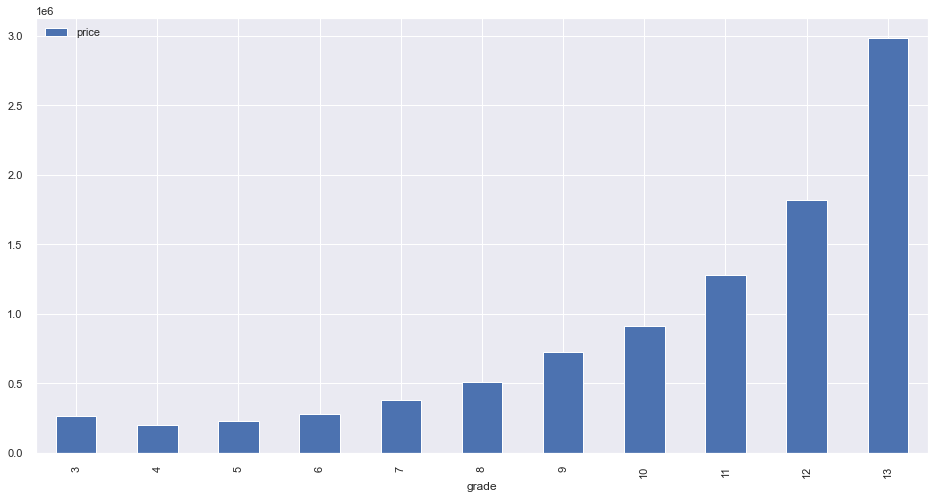

In [130]:
# Visualizing the median price by grade as a barplot
median_price_by_grade = df.groupby("grade").median()["price"].reset_index()
median_price_by_grade.plot(kind = "bar", x = "grade", y = "price", figsize = (16,8));

In [131]:
# Checking the grade feature for correlation with other indicators of a quality house
df.corr()["grade"]

price             0.668307
bedrooms          0.356095
bathrooms         0.665312
sqft_living       0.762398
sqft_lot          0.115122
floors            0.458694
waterfront        0.081195
view              0.249727
condition        -0.147326
grade             1.000000
sqft_above        0.755977
sqft_basement     0.164272
zipcode          -0.185710
lat               0.113787
long              0.200821
sqft_living15     0.713462
sqft_lot15        0.121435
age_lastchange   -0.459879
Name: grade, dtype: float64

### Rich, old golf player wants house near downtown
A hypothetical client (a rich, old golf player) is trying to find a house in close proximity to Seattle downtown. The 5 Golf Clubs closest to downtown are looked up on Google Maps and their respective zip codes are used in a list.

In [132]:
# Zipcodes for 5 best golf clubs are taken from google maps and some metrics that might be relevant to our client are compared.
zipcodes_golf_clubs = [98126, 98108, 98039, 98112, 98119]
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]
df_zipcodes_golf_clubs = df.copy()
df_zipcodes_golf_clubs = df_zipcodes_golf_clubs.loc[df_zipcodes_golf_clubs['zipcode'].isin(zipcodes_golf_clubs)]

df_zipcodes_golf_clubs.groupby("zipcode").median().reset_index()[["zipcode","price_per_sqft_living", "age_lastchange", "sqft_basement","floors"]]

,zipcode,price_per_sqft_living,age_lastchange,sqft_basement,floors
0,98039,565.165614,28.5,0.0,2.0
1,98108,208.301144,61.5,305.0,1.0
2,98112,424.581276,83.5,442.5,2.0
3,98119,416.652778,76.0,285.0,2.0
4,98126,274.390244,69.0,0.0,1.0


In [133]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

## Checking for correlation using plots and correlation matrix

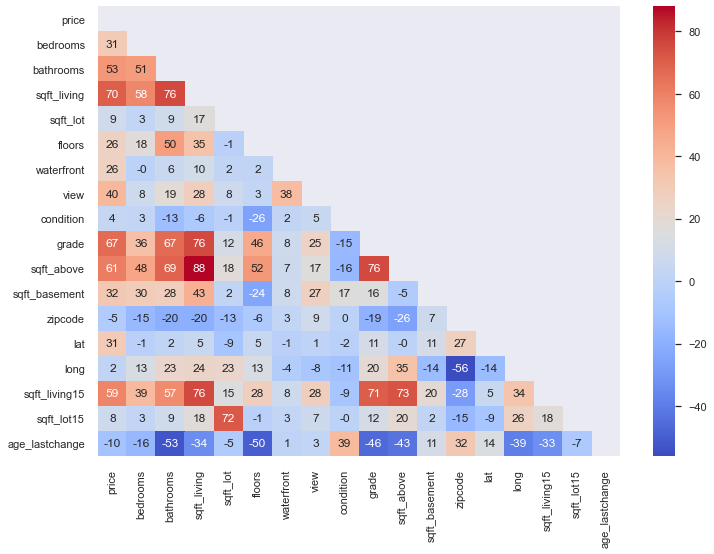

In [134]:
# Creating Heatmap for correlation coefficients of all variables
X_dum=pd.get_dummies(df.copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

1. Sqft_living, sqft_above, sqft_living15, bathrooms and view might be interesting features to consider.
2. They seem to have a good positive linear correlation with the price and the highest single R-squared values.
3. But there seems to be a lot of correlation between those features.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


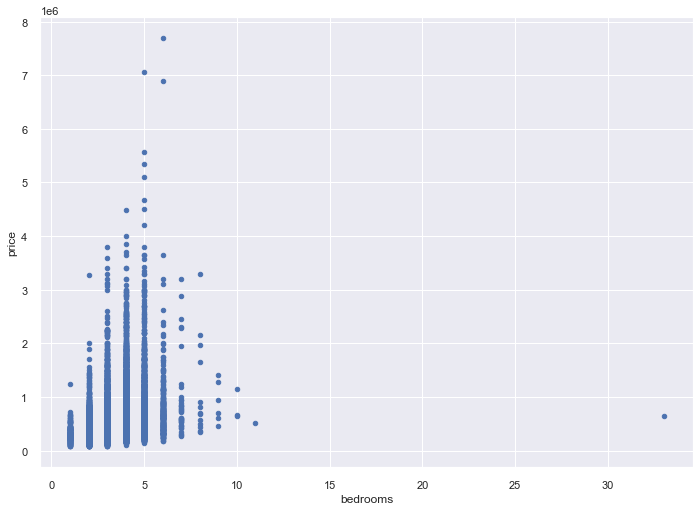

In [135]:
# Visualizing some of the interesting feature label combinations
df.plot(x = "bedrooms", y = "price", kind = "scatter");

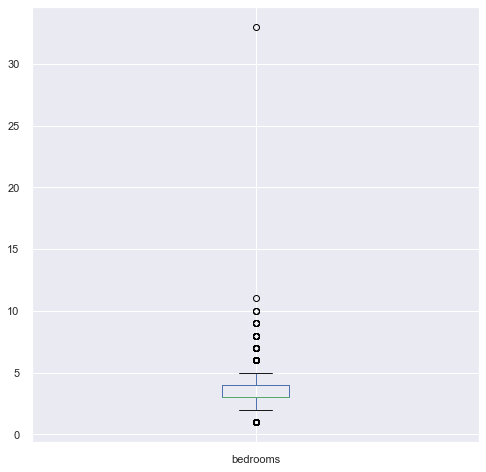

In [136]:
# There seem to be some outliers with a high number of bedrooms
# Those that are out of the boxplot will be removed
df.bedrooms.plot(kind='box',figsize=(8,8));

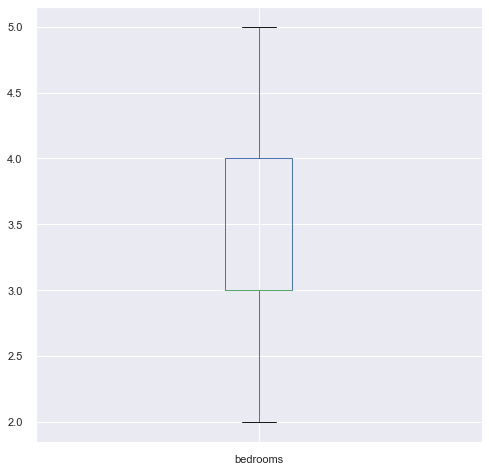

In [137]:
# Removing the outliers
Q1_bedrooms = df['bedrooms'].quantile(0.25)
Q3_bedrooms = df['bedrooms'].quantile(0.75)
IQR_bedrooms = Q3_bedrooms - Q1_bedrooms    #IQR is interquartile range. 

df =  df[(df['bedrooms'] >= (Q1_bedrooms - 1.5 * IQR_bedrooms)) & (df['bedrooms'] <= (Q3_bedrooms + 1.5 *IQR_bedrooms))]
df.bedrooms.plot(kind='box',figsize=(8,8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


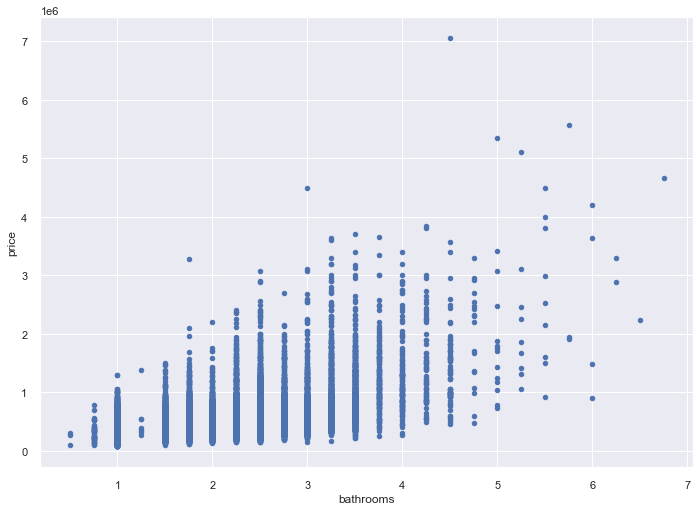

In [138]:
df.plot(x = "bathrooms", y = "price", kind = "scatter");

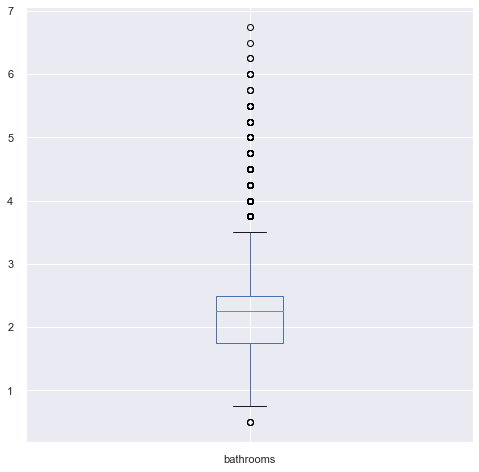

In [139]:
df.bathrooms.plot(kind='box',figsize=(8,8));

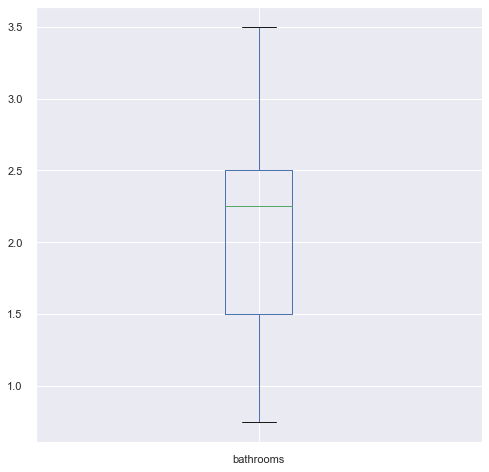

In [140]:
# Removing outliers for bathroom column
Q1_bathrooms = df['bathrooms'].quantile(0.25)
Q3_bathrooms = df['bathrooms'].quantile(0.75)
IQR_bathrooms = Q3_bathrooms - Q1_bathrooms    #IQR is interquartile range. 

df =  df[(df['bathrooms'] >= (Q1_bathrooms - 1.5 * IQR_bathrooms)) & (df['bathrooms'] <= (Q3_bathrooms + 1.5 *IQR_bathrooms))]
df.bathrooms.plot(kind='box',figsize=(8,8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


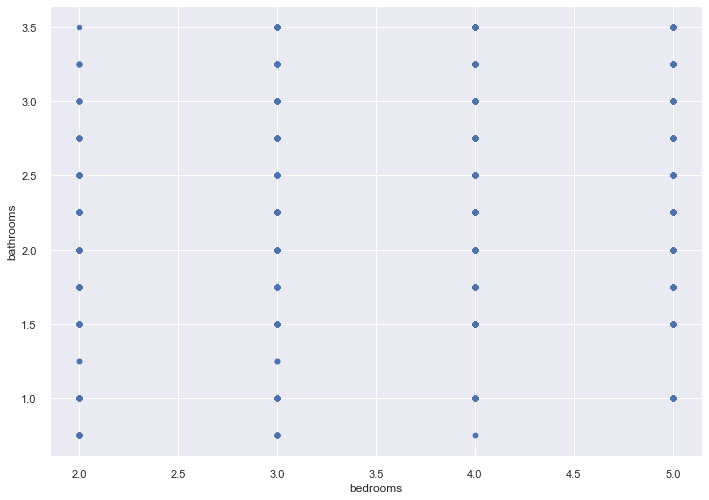

In [141]:
df.plot(x = "bedrooms", y = "bathrooms", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


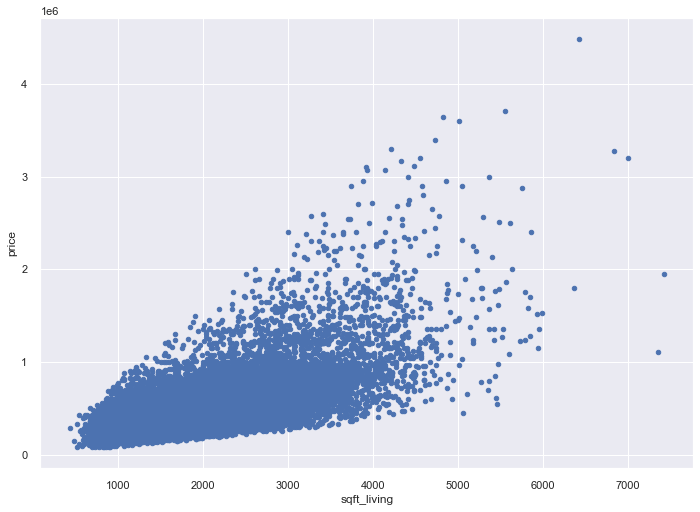

In [142]:
df.plot(x = "sqft_living", y = "price", kind = "scatter");

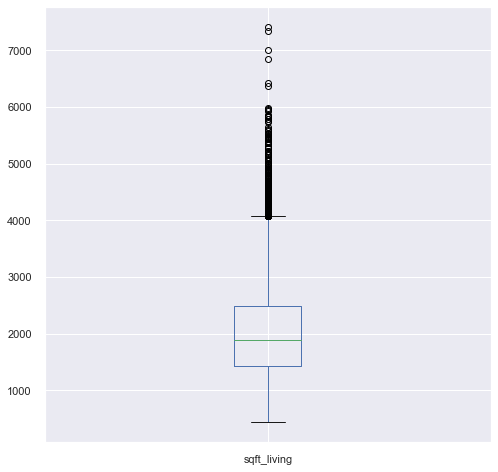

In [143]:
df.sqft_living.plot(kind='box',figsize=(8,8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


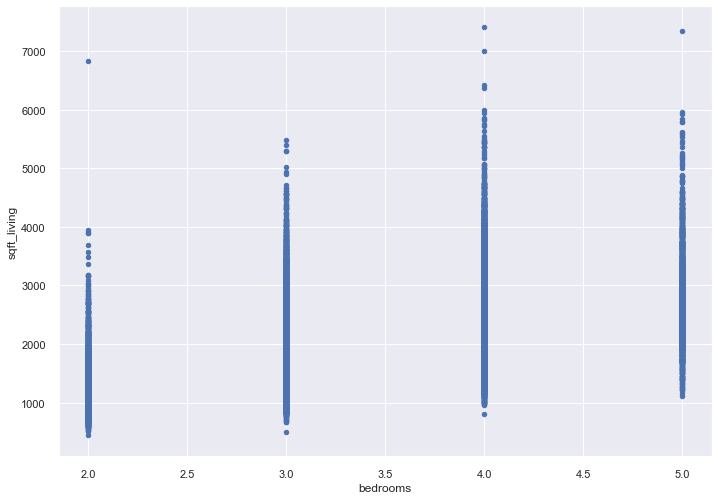

In [144]:
df.plot(x = "bedrooms", y = "sqft_living", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


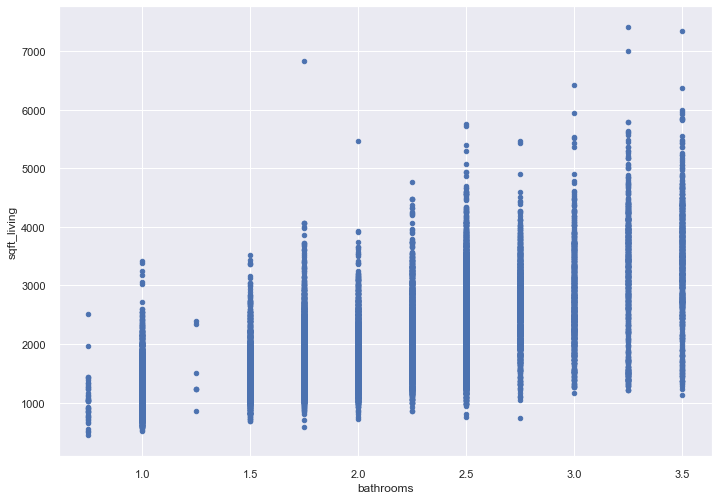

In [145]:
df.plot(x = "bathrooms", y = "sqft_living", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


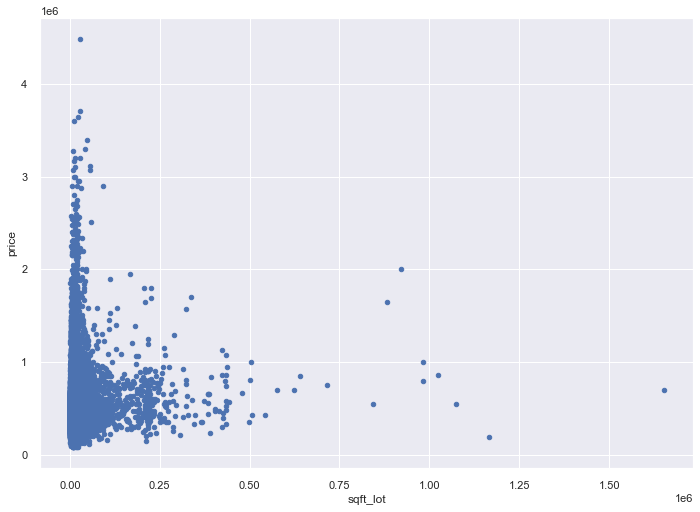

In [146]:
df.plot(x = "sqft_lot", y = "price", kind = "scatter");

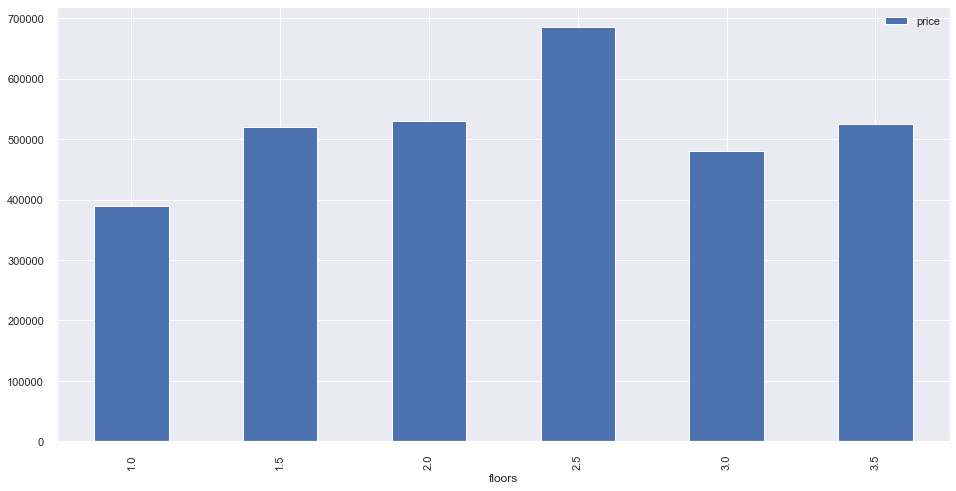

In [147]:
median_price_by_floors = df.groupby("floors").median()["price"].reset_index()
median_price_by_floors.plot(kind = "bar", x = "floors", y = "price", figsize = (16,8));

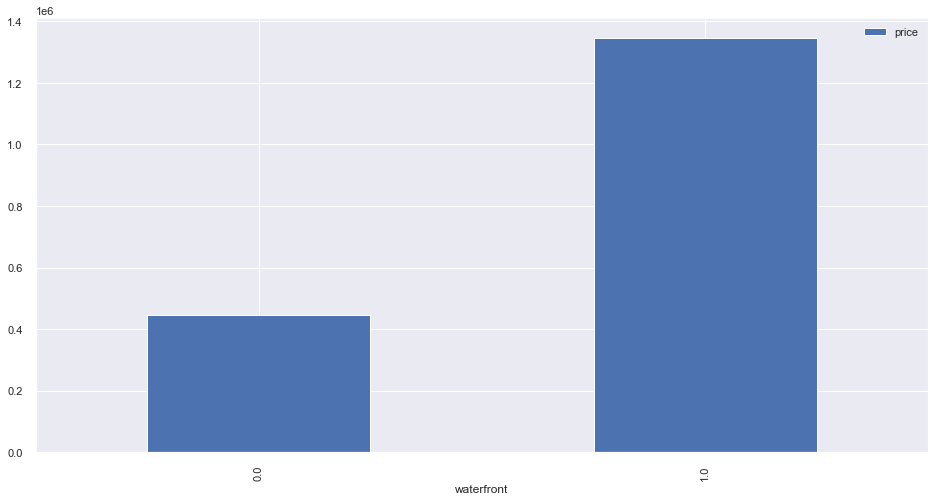

In [148]:
median_price_by_waterfront = df.groupby("waterfront").median()["price"].reset_index()
median_price_by_waterfront.plot(kind = "bar", x = "waterfront", y = "price", figsize = (16,8));

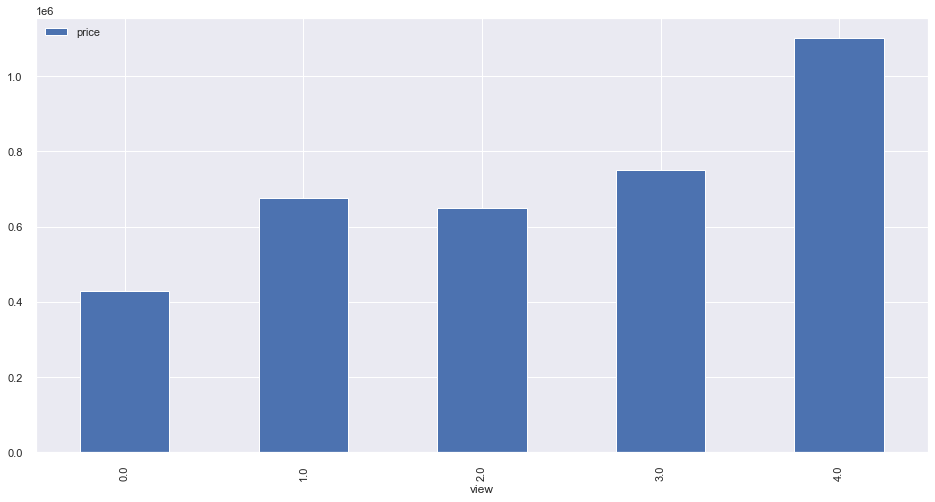

In [149]:
median_price_by_view = df.groupby("view").median()["price"].reset_index()
median_price_by_view.plot(kind = "bar", x = "view", y = "price", figsize = (16,8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


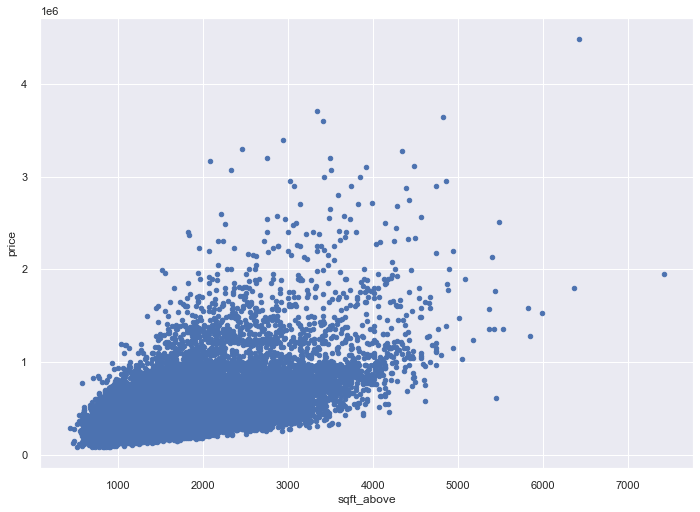

In [150]:
df.plot(x = "sqft_above", y = "price", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


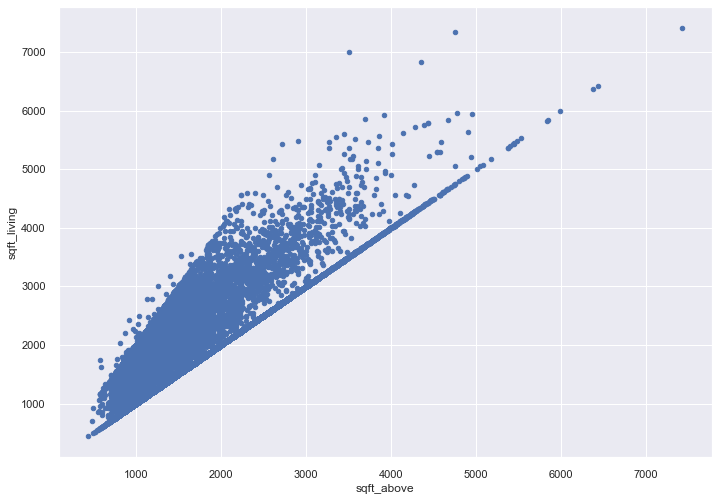

In [151]:
df.plot(x = "sqft_above", y = "sqft_living", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


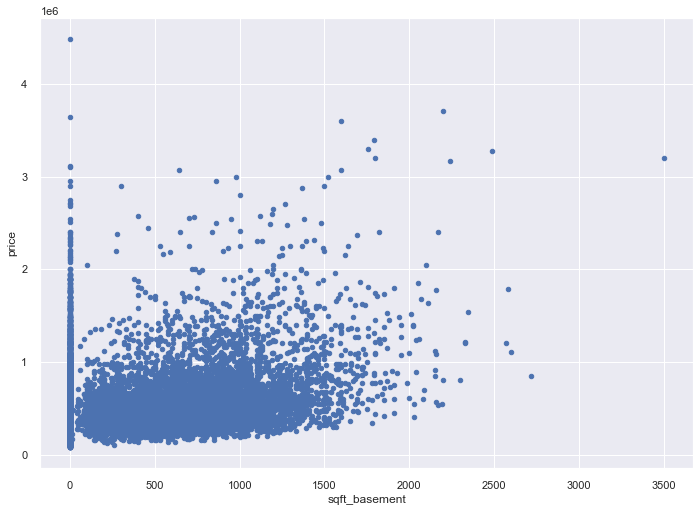

In [152]:
df.plot(x = "sqft_basement", y = "price", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


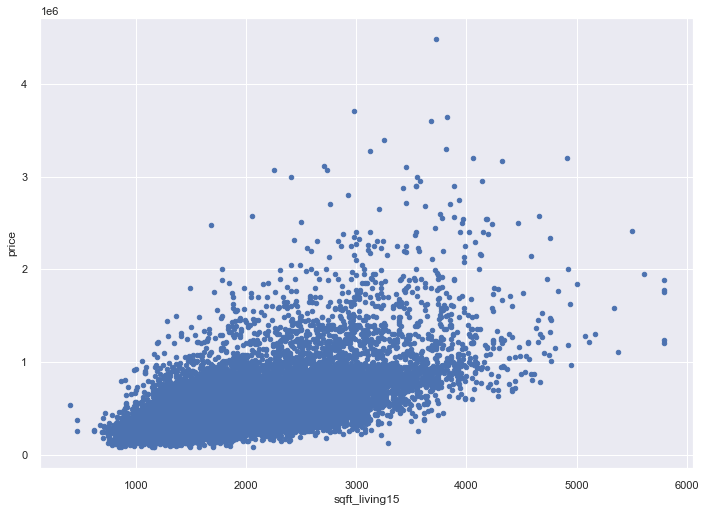

In [153]:
df.plot(x = "sqft_living15", y = "price", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


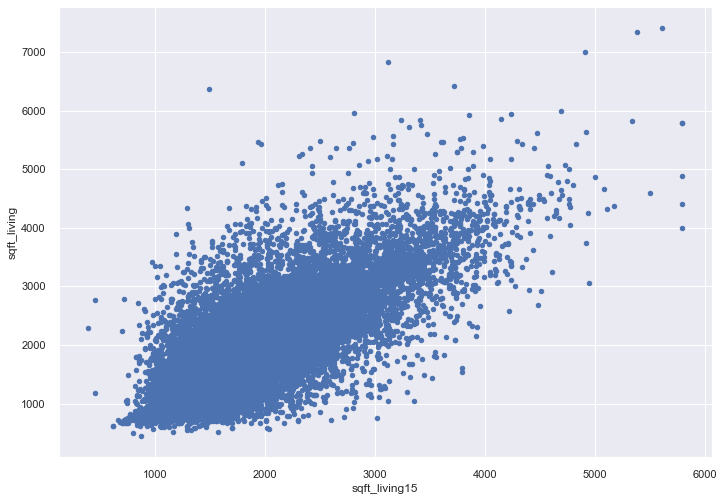

In [154]:
df.plot(x = "sqft_living15", y = "sqft_living", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


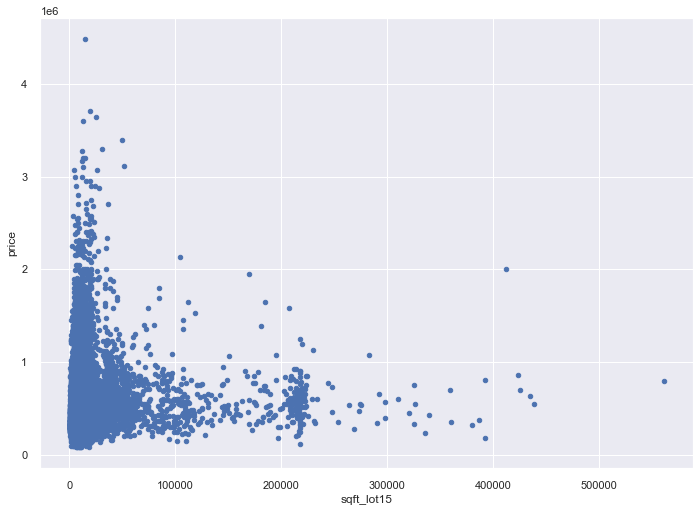

In [155]:
df.plot(x = "sqft_lot15", y = "price", kind = "scatter");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


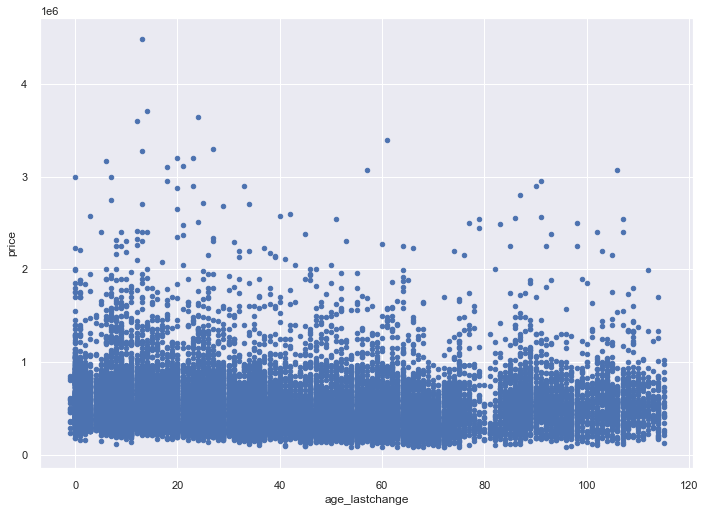

In [156]:
df.plot(x = "age_lastchange", y = "price", kind = "scatter");

## Splitting continuous and categorical variables

In [157]:
# Converting categorical variables to Strings
df[["waterfront","zipcode","bedrooms","bathrooms","floors","view","condition","grade"]] = df[["waterfront","zipcode","bedrooms","bathrooms","floors","view","condition","grade"]].astype(str)

# Dividing into continuous and categorical variables.
continuous_var = list(df.select_dtypes(
                        ['int64','float64','bool']).columns.values)
categorical_var=list(df.select_dtypes(
                        ['object']).columns.values)
categorical_var

['bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'zipcode']

## Creating Dummies for categorical variables

In [158]:
# Creating dummies for categorical variables and doing train-test-split

X = pd.get_dummies(df.copy(), drop_first = True)
X.drop("price", axis=1, inplace = True)
y = df["price"]

## Checking distribution of label and potentially scaling the data with log

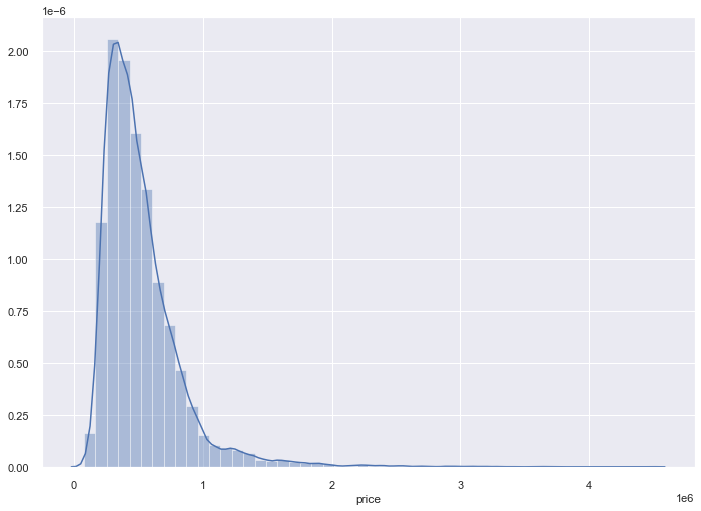

In [159]:
sns.distplot(y);

In [160]:
y = np.log(y)

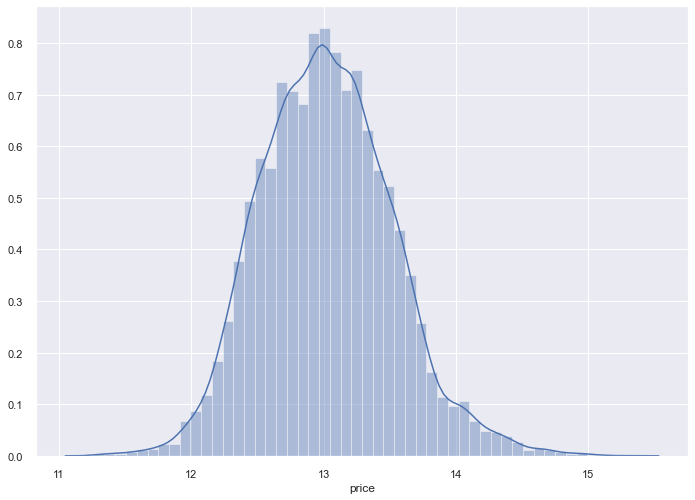

In [161]:
sns.distplot(y);

# Feature Engineering
No additional features are added in the first model.

# Predictive Modelling

## Train-Test-Split

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

## Setting up linear regression model, training and predicting labels for X_train and X_test

In [163]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_train_predict = linear_model.predict(X_train)
y_test_predict = linear_model.predict(X_test)

## Re-Transforming the labels and calculating R2-Score and RMSE for Training Set and Test Set

In [164]:
y_train_predict = np.exp(y_train_predict)
y_train = np.exp(y_train)
y_test_predict = np.exp(y_test_predict)
y_test = np.exp(y_test)

In [165]:
RMSE_train = np.round(mean_squared_error(y_train, y_train_predict)**0.5,2)
RMSE_test = np.round(mean_squared_error(y_test, y_test_predict)**0.5,2)

R2_train = np.round(r2_score(y_train, y_train_predict),2)
R2_test = np.round(r2_score(y_test, y_test_predict),2)

print(f"R2-Score for Training Set is: {R2_train}")
print(f"R2-Score for Test Set is: {R2_test}")
print(f"RMSE for Training Set is: {RMSE_train}")
print(f"RMSE for Training Set is: {RMSE_test}")

R2-Score for Training Set is: 0.86
R2-Score for Test Set is: 0.84
RMSE for Training Set is: 111718.09
RMSE for Training Set is: 122897.44


### Learning Curve
Plotting the learning curve for the current model.

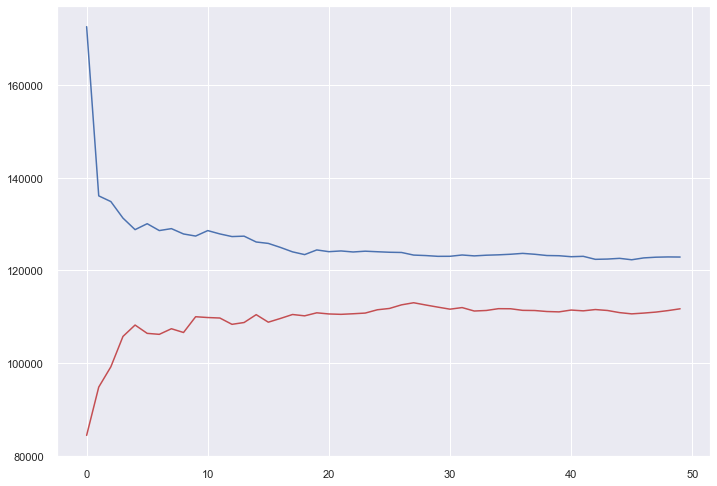

In [166]:
def plot_learning_curves(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
    train_errors, test_errors = [],[]
    training_sizes = np.linspace(len(X_train)/50, len(X_train), num = 50)
    training_sizes = training_sizes.astype(int)
    for m in training_sizes:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = np.exp(model.predict(X_train[:m]))
        y_test_predict = np.exp(model.predict(X_test))
        train_errors.append(mean_squared_error(y_train_predict, np.exp(y_train[:m])))
        test_errors.append(mean_squared_error(y_test_predict, np.exp(y_test)))
    plt.plot(np.sqrt(train_errors), "r-", label = "Training Set")
    plt.plot(np.sqrt(test_errors), "b-", label = "Test Set")    
        
plot_learning_curves(linear_model, X,y)

**Verdict:**
The R2-score of our linear regression model including all the features available satisfies the condition of the given task. The RMSE and the learning curve show, that the model is not refined enough to properly predict the house prices. The model is still underfitted and future work needs to be done.